In [28]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    GRU,
    Dense, 
    Concatenate
)
import tensorflow as tf
from tensorflow.keras.utils import plot_model,to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.load("../data/padded_x_train.npy")
data[:,:,3] -= 1 

In [27]:
out_steps = 3

In [33]:
dt_layer = Input(shape=(None,1),name="dt_in")
mag_layer = Input(shape=(None,2),name="mag_in")
fid_layer = Input(shape=(None,1),name="fid_in")

input_layer = Concatenate()
first_layer = GRU(units=10, activation="tanh", name="GRU")
out_dt = Dense(units=1,activation="tanh", name="dt_out")
out_mags = Dense(units=2,activation="tanh", name="mag_out")
out_fid = Dense(units=1,activation="softmax", name="fid_out")

def n_predict(dt, mag, fid):
    inp = input_layer([dt, mag, fid])
    lay = first_layer(inp)
    dt = out_dt(lay)
    mag = out_mags(lay)
    fid = out_fid(lay)
    return dt,mag,fid

preds_dt = []
preds_mag = []
preds_fid = []

pred_dt, pred_mag, pred_fid = n_predict(dt_layer,mag_layer,fid_layer)

preds_dt.append(pred_dt)
preds_mag.append(pred_mag)
preds_fid.append(pred_fid)

for n in range(1, out_steps-1):
    # Use the last prediction as input.
    pred_dt, pred_mag, pred_fid = n_predict(pred_dt,pred_mag,pred_fid)
    preds_dt.append(pred_dt)
    preds_mag.append(pred_mag)
    preds_fid.append(pred_fid)    
    
    
preds_dt = tf.stack(preds_dt)
preds_mag = tf.stack(preds_mag)
preds_fid = tf.stack(preds_fid)

preds_dt = tf.transpose(preds_dt, [1,0,2])
preds_mag = tf.transpose(preds_mag, [1,0,2])
preds_fid = tf.transpose(preds_fid, [1,0,2])

model = Model(inputs=[dt_layer,mag_layer,fid_layer], outputs = [preds_dt,preds_mag,preds_fid])

ValueError: Input 0 of layer GRU is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 4]

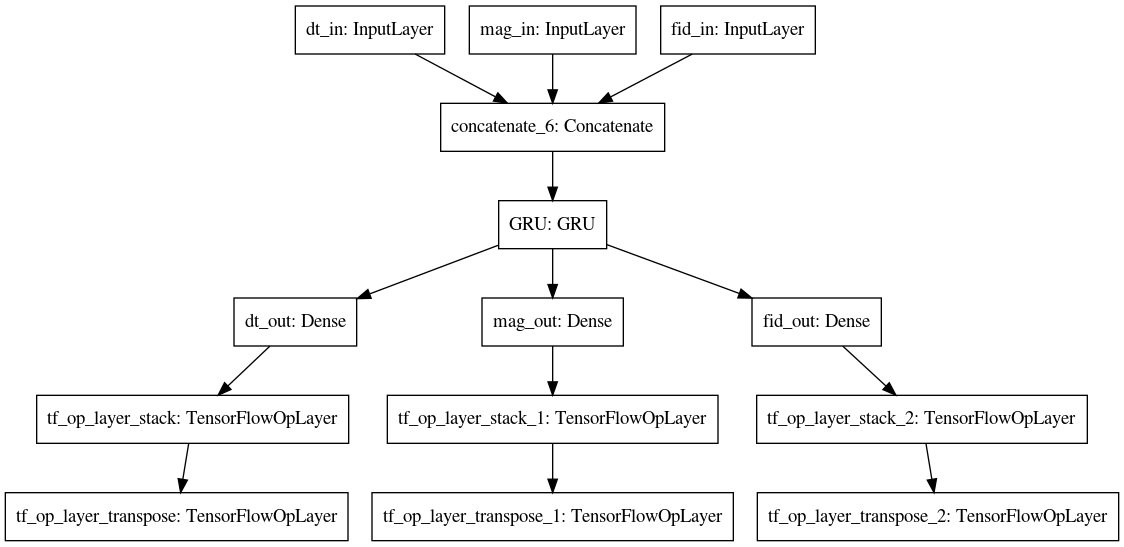

In [34]:
plot_model(model)

In [9]:
losses = {
    "dt_out": "mse",
    "mag_out": "mse",
    "fid_out": "binary_crossentropy"
}
model.compile(optimizer="adam", loss=losses)

In [10]:
np.random.seed(42)
indices = np.random.choice(np.arange(len(data)),10000)

In [11]:
sample_data = data[indices]

Indices
- 0 dt
- 1,2 mag, sigmag
- 3 band

In [23]:
X_train, y_train = sample_data[:,:-3,:],  sample_data[:,-3:,:]
y_dt = y_train[:,0,0].reshape((-1,1))
y_mag = y_train[:,0,1:3]
y_band = y_train[:,0,3].reshape((-1,1))


x_dt = np.expand_dims(X_train[:,:,0],axis=2)
x_mag = X_train[:,:,1:3]
x_did = np.expand_dims(X_train[:,:,3],axis=2)

In [24]:
ins = {
    "dt_in":x_dt,
    "mag_in": x_mag,
    "fid_in":x_did
}
outs = {
     "dt_out": y_dt,
    "mag_out": y_mag,
    "fid_out": y_band
}
model.fit(ins,outs,batch_size=1000)

W0807 20:24:24.803229 140315807409984 deprecation.py:323] From /home/tronco/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10000/10000 [==============================] - 4s 398us/sample - loss: 214.1175 - dt_out_loss: 45.6444 - mag_out_loss: 161.5777 - fid_out_loss: 6.8954
